순환신경망(RNN)을 활용한 코로나 확진자 예측 예제 (다변수활용)

국토연구원 국토데이터랩 | 장요한 (ycanns@krihs.re.kr)

1. INITIALIZATION

In [1]:
""" 
필요한 함수들을 불러오기: 
keras - 신경망 계산 가속화, 
tensorflow - 벡터행렬 및 미분 계산, 
numpy - 복잡한 산술계산,
matplotlib - 그래프 그리기
"""
# 필요한 함수 불러오기
from keras.models import Sequential # ANNs model
from keras.layers import SimpleRNN, Dense # fully-connected layer with activation function
from sklearn.preprocessing import StandardScaler # library for using Normalization
from sklearn.metrics import mean_squared_error # 오차계산을 위한 함수 평균제곱오차(MSE)
from sklearn.model_selection import train_test_split # 데이터의 훈련과 검증 데이터로 구분
from tensorflow.keras import layers, models # 아키텍처 시각화를 위한 모듈
from tensorflow import keras # tensorflow + keras

import math # 수학계산 라이브러리
import numpy as np # 복잡한 산술계산
import matplotlib.pyplot as plt # 그래프 그리기
import pandas as pd # 매트릭스 등의 계산을 위한 라이브러리

In [2]:
# 깃허브에 있는 데이터를 임시적으로 다운로드
!git clone https://github.com/yhlee1627/deeplearning.git
dataframe = pd.read_csv('/content/deeplearning/corona_daily.csv', engine='python', skipfooter=3)
"""
pd.read_csv 와 read_csv의 차이?
from pandas import read_csv
dataframe = read_csv('/content/deeplearning/corona_daily.csv', usecols=[3], engine='python', skipfooter=3)
"""
dataframe


Cloning into 'deeplearning'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), 3.03 KiB | 775.00 KiB/s, done.


,Date,Inspected,Negative,Confirmed,Recovered,Deaths
0,2020-02-06,1352,1001,24,2,0
1,2020-02-07,2097,1134,24,2,0
2,2020-02-08,2598,1683,27,3,0
3,2020-02-09,3110,2552,27,3,0
4,2020-02-10,4325,3535,28,4,0
...,...,...,...,...,...,...
107,2020-05-23,820289,788766,11190,10213,266
108,2020-05-24,826437,796142,11206,10226,267
109,2020-05-25,839475,806206,11225,10275,269
110,2020-05-26,852876,820550,11265,10295,269


2. DATA CHECKING: summary statistics, distribution

2.1. Summary Statistics

In [3]:
dataframe.describe()


,Inspected,Negative,Confirmed,Recovered,Deaths
count,112.000000,112.00000,112.000000,112.000000,112.000000
mean,402732.258929,380693.06250,7841.169643,4984.607143,147.044643
std,265883.064283,260758.89632,4052.162530,4088.498443,103.033922
min,1352.000000,1001.00000,24.000000,2.000000,0.000000
25%,160190.250000,132209.25000,6154.500000,103.000000,40.250000
50%,437508.000000,409092.50000,10019.000000,5924.500000,171.500000
75%,620678.000000,601264.00000,10767.250000,9062.250000,247.250000
max,868666.000000,834952.00000,11344.000000,10340.000000,269.000000


2.2. Data distributions

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'counts')

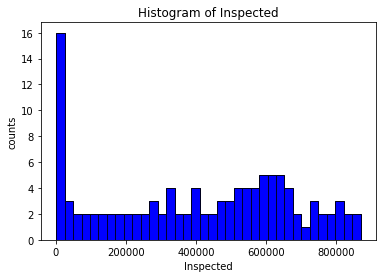

In [4]:
import seaborn as sns

# matplotlib histogram
plt.hist(dataframe['Inspected'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(dataframe['Inspected'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Inspected')
plt.xlabel('Inspected')
plt.ylabel('counts')

In [5]:
dataframe.columns

Index(['Date', 'Inspected', 'Negative', 'Confirmed', 'Recovered', 'Deaths'], dtype='object')

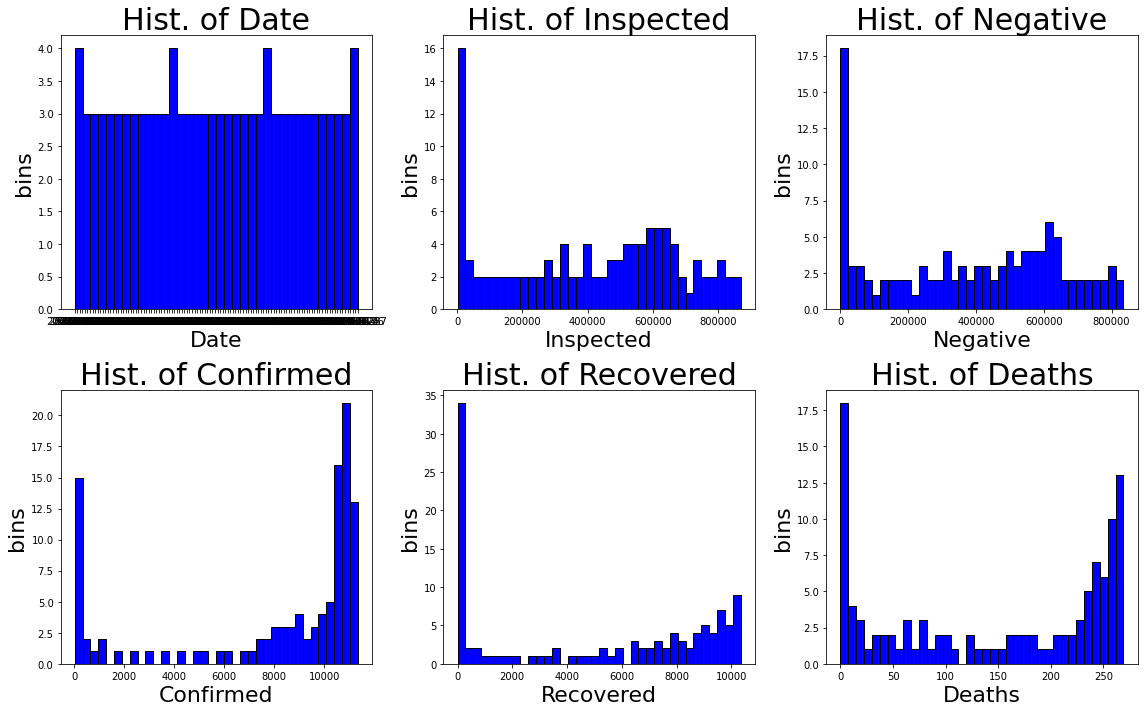

In [6]:
# Show 4 different binwidths
i = 0
plt.figure(figsize = (16, 10))
for value_in_pd in dataframe.columns:
    
    # Set up the plot
    ax = plt.subplot(2, 3, i + 1)
    
    # Draw the plot
    ax.hist(dataframe[value_in_pd], bins = int(180/5),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Hist. of %s' % value_in_pd, size = 30)
    ax.set_xlabel('%s' % value_in_pd, size = 22)
    ax.set_ylabel('bins', size= 22)
    i += 1
plt.tight_layout()
plt.show()

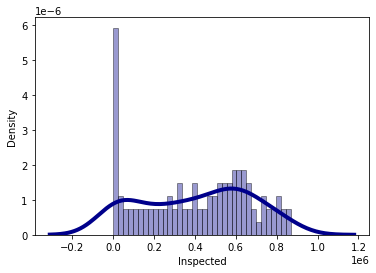

In [7]:
# Density Plot and Histogram of all arrival delays
sns.distplot(dataframe['Inspected'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


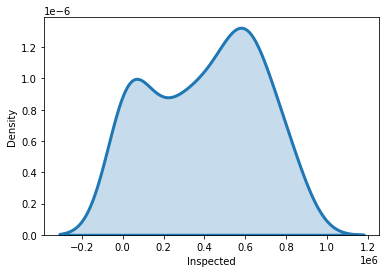

In [8]:
sns.distplot(dataframe['Inspected'], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label = value_in_pd)

In [9]:
dataframe.columns[1:len(dataframe.columns)]

Index(['Inspected', 'Negative', 'Confirmed', 'Recovered', 'Deaths'], dtype='object')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

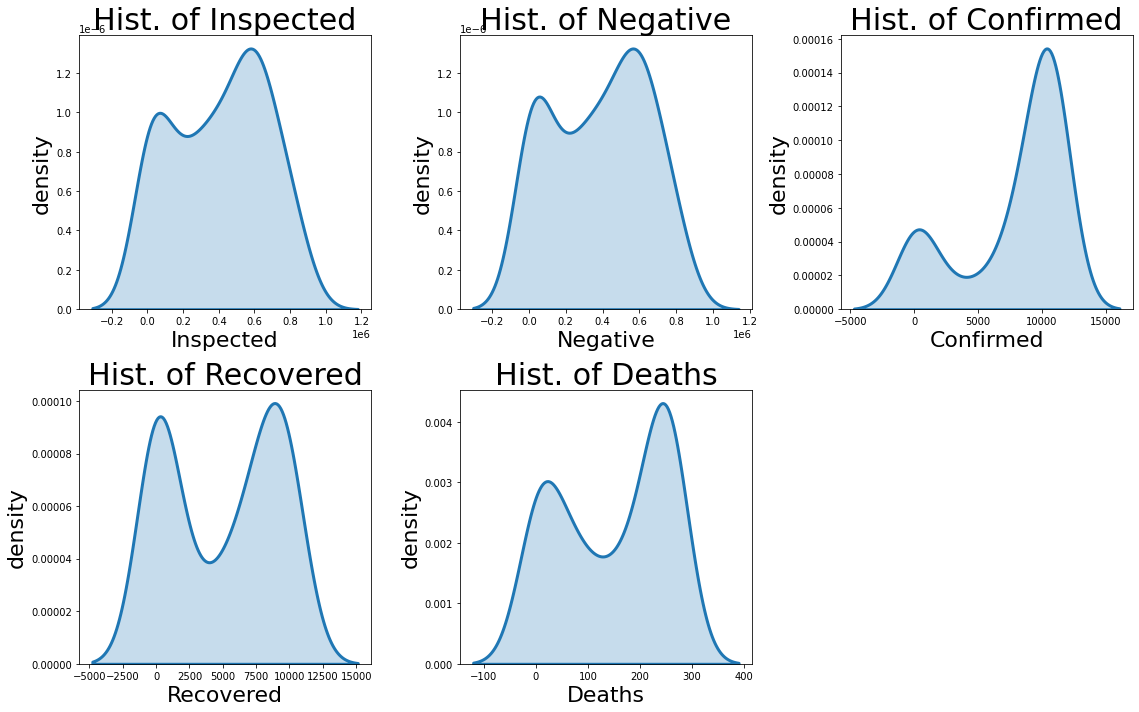

In [10]:
# Show 4 different binwidths
i = 0
plt.figure(figsize = (16, 10))
for value_in_pd in dataframe.columns[1:len(dataframe.columns)]:
    
    # Set up the plot
    ax = plt.subplot(2, 3, i + 1)
    
    # Draw the plot
    sns.distplot(dataframe[value_in_pd], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                 label = value_in_pd)

    # Title and labels
    ax.set_title('Hist. of %s' % value_in_pd, size = 30)
    ax.set_xlabel('%s' % value_in_pd, size = 22)
    ax.set_ylabel('density', size= 22)
    i += 1
plt.tight_layout()
plt.show()


2.3. Data Pre-processing

In [11]:
dataframe['Date'].head()


0    2020-02-06
1    2020-02-07
2    2020-02-08
3    2020-02-09
4    2020-02-10
Name: Date, dtype: object

In [12]:
#개별 값의 치환
'2020-02-06'.replace("-", "")


'20200206'

In [13]:
# Date format에 '-' 없애기
dataframe['Date'] = dataframe['Date'].replace('-','', regex=True)
dataframe


,Date,Inspected,Negative,Confirmed,Recovered,Deaths
0,20200206,1352,1001,24,2,0
1,20200207,2097,1134,24,2,0
2,20200208,2598,1683,27,3,0
3,20200209,3110,2552,27,3,0
4,20200210,4325,3535,28,4,0
...,...,...,...,...,...,...
107,20200523,820289,788766,11190,10213,266
108,20200524,826437,796142,11206,10226,267
109,20200525,839475,806206,11225,10275,269
110,20200526,852876,820550,11265,10295,269


In [14]:
# data의 컬럼순서 바꾸기
dataframe = dataframe[['Date', 'Inspected', 'Negative', 'Recovered', 'Deaths', 'Confirmed']]
dataframe

,Date,Inspected,Negative,Recovered,Deaths,Confirmed
0,20200206,1352,1001,2,0,24
1,20200207,2097,1134,2,0,24
2,20200208,2598,1683,3,0,27
3,20200209,3110,2552,3,0,27
4,20200210,4325,3535,4,0,28
...,...,...,...,...,...,...
107,20200523,820289,788766,10213,266,11190
108,20200524,826437,796142,10226,267,11206
109,20200525,839475,806206,10275,269,11225
110,20200526,852876,820550,10295,269,11265


In [15]:
dataframe['Confirmed']


0         24
1         24
2         27
3         27
4         28
       ...  
107    11190
108    11206
109    11225
110    11265
111    11344
Name: Confirmed, Length: 112, dtype: int64

In [16]:
dataframe.iloc[:, 0:(dataframe.shape[1]-1)]

,Date,Inspected,Negative,Recovered,Deaths
0,20200206,1352,1001,2,0
1,20200207,2097,1134,2,0
2,20200208,2598,1683,3,0
3,20200209,3110,2552,3,0
4,20200210,4325,3535,4,0
...,...,...,...,...,...
107,20200523,820289,788766,10213,266
108,20200524,826437,796142,10226,267
109,20200525,839475,806206,10275,269
110,20200526,852876,820550,10295,269


In [17]:
x_dataset = dataframe.iloc[:, 0:(dataframe.shape[1]-1)].astype('float32')
y_dataset = dataframe[['Confirmed']].astype('float32')
print(x_dataset)
print(y_dataset)

           Date  Inspected  Negative  Recovered  Deaths
0    20200206.0     1352.0    1001.0        2.0     0.0
1    20200208.0     2097.0    1134.0        2.0     0.0
2    20200208.0     2598.0    1683.0        3.0     0.0
3    20200208.0     3110.0    2552.0        3.0     0.0
4    20200210.0     4325.0    3535.0        4.0     0.0
..          ...        ...       ...        ...     ...
107  20200524.0   820289.0  788766.0    10213.0   266.0
108  20200524.0   826437.0  796142.0    10226.0   267.0
109  20200524.0   839475.0  806206.0    10275.0   269.0
110  20200526.0   852876.0  820550.0    10295.0   269.0
111  20200528.0   868666.0  834952.0    10340.0   269.0

[112 rows x 5 columns]
     Confirmed
0         24.0
1         24.0
2         27.0
3         27.0
4         28.0
..         ...
107    11190.0
108    11206.0
109    11225.0
110    11265.0
111    11344.0

[112 rows x 1 columns]


2.5. Data Normalization

In [18]:
sc_x = StandardScaler()
X_Dataset = sc_x.fit_transform(x_dataset) # 데이터 정규화 변환 (sc_x 는 training)
print(X_Dataset.shape)
X_Dataset

(112, 5)


array([[-1.5284351 , -1.5163968 , -1.4626483 , -1.224166  , -1.4335622 ],
       [-1.509712  , -1.5135822 , -1.4621359 , -1.224166  , -1.4335622 ],
       [-1.509712  , -1.5116894 , -1.4600211 , -1.2239203 , -1.4335622 ],
       [-1.509712  , -1.5097551 , -1.4566735 , -1.2239203 , -1.4335622 ],
       [-1.490989  , -1.5051649 , -1.4528868 , -1.2236747 , -1.4335622 ],
       [-1.472266  , -1.5002574 , -1.4479715 , -1.2229376 , -1.4335622 ],
       [-1.472266  , -1.4969063 , -1.4436954 , -1.2229376 , -1.4335622 ],
       [-1.472266  , -1.4941446 , -1.4407755 , -1.2229376 , -1.4335622 ],
       [-1.453543  , -1.4922858 , -1.4389688 , -1.2224462 , -1.4335622 ],
       [-1.4348198 , -1.4906727 , -1.4370466 , -1.2224462 , -1.4335622 ],
       [-1.4348198 , -1.4885683 , -1.4357638 , -1.2222005 , -1.4335622 ],
       [-1.4348198 , -1.4845864 , -1.4321312 , -1.2217091 , -1.4335622 ],
       [-1.4160968 , -1.4792935 , -1.4280864 , -1.2207264 , -1.4335622 ],
       [-1.3973738 , -1.471628  , -1.4

In [19]:
sc_y = StandardScaler()
Y_Dataset = sc_y.fit_transform(y_dataset) # 데이터 정규화 변환 (sc_y 는 target)
print(Y_Dataset.shape)
Y_Dataset

(112, 1)


array([[-1.9378055 ],
       [-1.9378055 ],
       [-1.9370619 ],
       [-1.9370619 ],
       [-1.936814  ],
       [-1.936814  ],
       [-1.936814  ],
       [-1.936814  ],
       [-1.936814  ],
       [-1.9365661 ],
       [-1.9363182 ],
       [-1.9360703 ],
       [-1.9311125 ],
       [-1.9179742 ],
       [-1.8931851 ],
       [-1.8364182 ],
       [-1.7945246 ],
       [-1.7372618 ],
       [-1.7015655 ],
       [-1.6311644 ],
       [-1.5059795 ],
       [-1.3644338 ],
       [-1.1628984 ],
       [-1.0176344 ],
       [-0.8996383 ],
       [-0.7509037 ],
       [-0.62299204],
       [-0.5144158 ],
       [-0.38600826],
       [-0.26627693],
       [-0.17530094],
       [-0.11382399],
       [-0.08135028],
       [-0.02136067],
       [ 0.00689889],
       [ 0.03416689],
       [ 0.06069123],
       [ 0.07953094],
       [ 0.09787487],
       [ 0.11869771],
       [ 0.14175157],
       [ 0.17943099],
       [ 0.20099752],
       [ 0.23743749],
       [ 0.2617308 ],
       [ 0

2.6. Data Split (Training + Testing)


In [21]:
Train_ratio = math.ceil(len(X_Dataset)*0.75)

In [22]:
X_train = X_Dataset[0:Train_ratio,]
Y_train = Y_Dataset[0:Train_ratio,]
X_test = X_Dataset[(Train_ratio+1):len(X_Dataset),]
Y_test = Y_Dataset[(Train_ratio+1):len(X_Dataset),]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape) # 훈련데이터와 검증데이터의 크기 확인

(84, 5) (84, 1) (27, 5) (27, 1)


2.7. DATA Reshape

In [23]:
# 데이터의 변환을 위한 함수생성: RNN의 데이터포맷으로 변환
def create_dataset(X_dataset, Y_dataset, look_back=3):
  x_data = []
  y_data = []
  for i in range(len(X_dataset)-look_back-1):
    x_data.append(X_dataset[i:(i+look_back)])
    y_data.append(Y_dataset[i + look_back][0])
  return np.array(x_data), np.array(y_data)

In [24]:
look_back = 3 # 3개의 이전 데이터 (Look back)
x_train, y_train = create_dataset(X_train, Y_train, look_back)
x_test, y_test = create_dataset(X_test, Y_test, look_back)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(80, 3, 5) (80,)
(23, 3, 5) (23,)


2.8. Data reshape (if, needed)

In [25]:
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[2], x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[2], x_test.shape[1]))

print(X_train.shape)
print(X_test.shape)

(80, 5, 3)
(23, 5, 3)


In [26]:
print(x_train)

[[[-1.5284351  -1.5163968  -1.4626483  -1.224166   -1.4335622 ]
  [-1.509712   -1.5135822  -1.4621359  -1.224166   -1.4335622 ]
  [-1.509712   -1.5116894  -1.4600211  -1.2239203  -1.4335622 ]]

 [[-1.509712   -1.5135822  -1.4621359  -1.224166   -1.4335622 ]
  [-1.509712   -1.5116894  -1.4600211  -1.2239203  -1.4335622 ]
  [-1.509712   -1.5097551  -1.4566735  -1.2239203  -1.4335622 ]]

 [[-1.509712   -1.5116894  -1.4600211  -1.2239203  -1.4335622 ]
  [-1.509712   -1.5097551  -1.4566735  -1.2239203  -1.4335622 ]
  [-1.490989   -1.5051649  -1.4528868  -1.2236747  -1.4335622 ]]

 ...

 [[ 0.512376    0.7056758   0.7262119   0.863935    0.9062369 ]
  [ 0.512376    0.7269872   0.7492172   0.8968572   0.9062369 ]
  [ 0.512376    0.73878956  0.76221454  0.9170036   0.9257352 ]]

 [[ 0.512376    0.7269872   0.7492172   0.8968572   0.9062369 ]
  [ 0.512376    0.73878956  0.76221454  0.9170036   0.9257352 ]
  [ 0.531099    0.7515401   0.7755778   0.9285509   0.93548435]]

 [[ 0.512376    0.738789

In [27]:
# 변수를 지우고 싶을때..
# del (model)

3. DESIGN RNN ARCHITECTURE

In [28]:
model = Sequential()
model.add(SimpleRNN(look_back, input_shape=(look_back, x_train.shape[2]))) # 3개의 뉴런
model.add(Dense(1, activation="linear")) # 1단위의 확진자 수 예측
model.compile(loss='mse', optimizer='sgd') # 손실함수 및 오차를 줄이기 위한 방법 (adam 또는 확률적경사하강법(SGD))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 27        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


Model Visualization

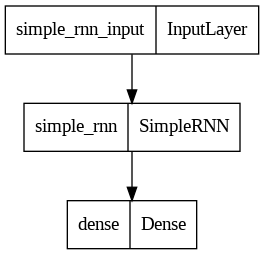

In [29]:
# Simple Architecture
keras.utils.plot_model(model)

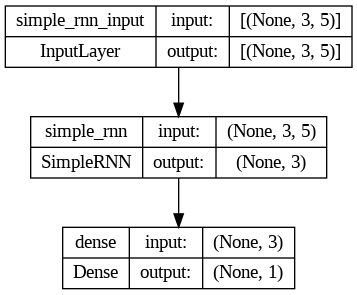

In [30]:
# Architecture with variables
keras.utils.plot_model(model, show_shapes=True)

In [31]:
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
80/80 [==============================] - 3s 2ms/step - loss: 0.1292
Epoch 2/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0646
Epoch 3/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0412
Epoch 4/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0304
Epoch 5/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 6/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 7/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 8/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 9/100
80/80 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 10/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 11/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 12/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 13/100
80/80 [=================

4. PREDICTION

In [32]:
# 모델 예측
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

# 정규화 이전의 값으로 변환 (inverse_transform)
TrainPredict = sc_y.inverse_transform(trainPredict) 
Y_train = sc_y.inverse_transform([y_train])
TestPredict = sc_y.inverse_transform(testPredict)
Y_test = sc_y.inverse_transform([y_test])

1/1 [==============================] - 0s 14ms/step


In [33]:
testPredict

array([[0.9574729 ],
       [0.99433684],
       [1.0153555 ],
       [1.0377997 ],
       [1.060773  ],
       [1.0762917 ],
       [1.0861251 ],
       [1.1105381 ],
       [1.1909258 ],
       [1.3214674 ],
       [1.4602944 ],
       [1.5843532 ],
       [1.6966949 ],
       [1.7514021 ],
       [1.7905152 ],
       [1.8487566 ],
       [1.8951161 ],
       [1.9386451 ],
       [1.9888833 ],
       [2.0409791 ],
       [2.0711472 ],
       [2.0953026 ],
       [2.1258023 ]], dtype=float32)

5. CHECK MODEL ACCURACY

In [34]:
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 8066.54 RMSE
Test Score: 11017.98 RMSE


6. VISUALIZATION

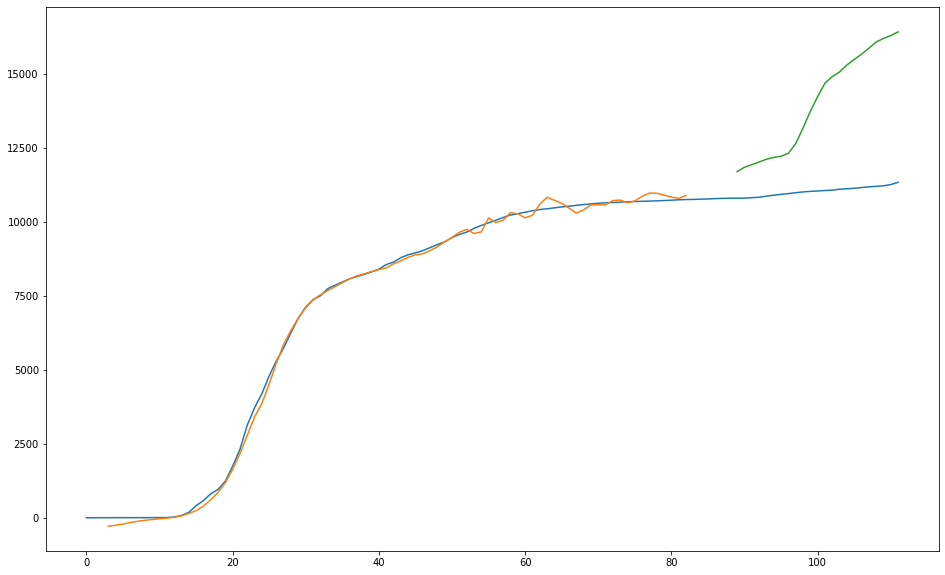

In [35]:
trainPredictPlot = np.empty_like(y_dataset)
trainPredictPlot[:, ] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, ] = TrainPredict
testPredictPlot = np.empty_like(y_dataset)
testPredictPlot[:, ] = np.nan
testPredictPlot[len(trainPredict)+1+(look_back+1)*2:len(y_dataset), ] = TestPredict

plt.figure(figsize = (16, 10))
plt.plot(y_dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

7. ADDITONAL VISUALIZATIONS: plotly

In [36]:
import plotly.express as px

fig = px.line(dataframe, x="Date", y=dataframe.columns[1:dataframe.shape[1]])
fig.show()

END code